In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
#from keras.applications import MobileNet, MobileNetV2, VGG16
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense, BatchNormalization
#from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import files
files.upload()

Saving BrainTumor.zip to BrainTumor.zip


In [4]:
!unzip BrainTumor.zip

Archive:  BrainTumor.zip
   creating: BrainTumor/Testing/
   creating: BrainTumor/Testing/glioma_tumor/
  inflating: BrainTumor/Testing/glioma_tumor/image(1).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(10).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(100).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(11).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(12).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(13).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(14).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(15).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(16).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(17).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(18).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(19).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(2).jpg  
  inflating: BrainTumor/Testing/glioma_tumor/image(20).jpg  
  inflating: BrainTumor/Testing/glioma_tumo

In [5]:
path = "/content/BrainTumor"

In [6]:
list(os.listdir(path))

['Training', 'Testing']

In [8]:
list(os.listdir(path + "/Training"))

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

In [11]:
list(os.listdir(path + "/Testing"))

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

In [12]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}

inverse_class_map = {
    0: 'no_tumor',
    1: 'glioma_tumor',
    2: 'meningioma_tumor',
    3: 'pituitary_tumor'
}

In [13]:
h, w = 224, 224
batch_size = 32
epochs = 100

In [14]:
IMAGE = []
LABELS = []

for label in labels:
    folderPath = os.path.join('/content/BrainTumor/Training', label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(h, w))
        IMAGE.append(img)
        LABELS.append(class_map[label])
            
        
for label in labels:
    folderPath = os.path.join('/content/BrainTumor/Testing', label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(h, w))
        IMAGE.append(img)
        LABELS.append(class_map[label])
        
X = np.array(IMAGE)
y = np.array(LABELS)

100%|██████████| 74/74 [00:00<00:00, 110.44it/s]


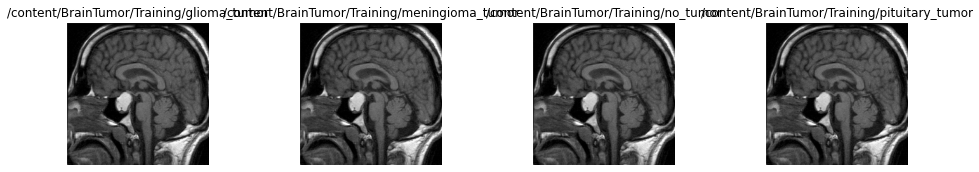

In [24]:
plt.figure(figsize=(16, 12))

path = '/content/BrainTumor/Training'
fileNames = ['/content/BrainTumor/Training/glioma_tumor/gg (10).jpg', '/content/BrainTumor/Training/meningioma_tumor/m (108).jpg', '/content/BrainTumor/Training/no_tumor/image (16).jpg', '/content/BrainTumor/Training/pituitary_tumor/p (12).jpg']
fileLabels = ['/content/BrainTumor/Training/glioma_tumor', '/content/BrainTumor/Training/meningioma_tumor', '/content/BrainTumor/Training/no_tumor', '/content/BrainTumor/Training/pituitary_tumor']

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    #img = mpimg.imread(path + fileNames[i])
    img = cv2.resize(img, (h, w))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

In [25]:
X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(y), test_size=0.1, random_state=42)

In [26]:
 base_model = MobileNetV2(
     input_shape=(h, w, 3), 
     weights='imagenet',
     include_top=False, 
     pooling='avg'
 )

#base_model = VGG16(
#    input_shape=(h, w, 3), 
#   weights='imagenet',
#   include_top=False, 
#   pooling='max'
#)

base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [27]:
base_model.trainable = False

output_class = 4

model = Sequential([
    base_model,
    Dropout(rate=0.5),
    Dense(output_class, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [29]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [30]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = batch_size), validation_data = (X_test, y_test),
                    steps_per_epoch = len(X_train) / batch_size, epochs = epochs, callbacks = callbacks)

Epoch 1/100
91/91 [==============================] - 133s 1s/step - loss: 1.1410 - accuracy: 0.5284 - val_loss: 2.3051 - val_accuracy: 0.1865
Epoch 2/100
91/91 [==============================] - 131s 1s/step - loss: 0.7567 - accuracy: 0.7004 - val_loss: 2.8088 - val_accuracy: 0.1529
Epoch 3/100
91/91 [==============================] - 125s 1s/step - loss: 0.6698 - accuracy: 0.7474 - val_loss: 3.2078 - val_accuracy: 0.1437
Epoch 4/100
91/91 [==============================] - 126s 1s/step - loss: 0.6036 - accuracy: 0.7661 - val_loss: 2.9930 - val_accuracy: 0.1407
Epoch 5/100
91/91 [==============================] - 123s 1s/step - loss: 0.5865 - accuracy: 0.7746 - val_loss: 2.7628 - val_accuracy: 0.1407
Epoch 6/100
91/91 [==============================] - 123s 1s/step - loss: 0.5635 - accuracy: 0.7841 - val_loss: 3.1122 - val_accuracy: 0.1407


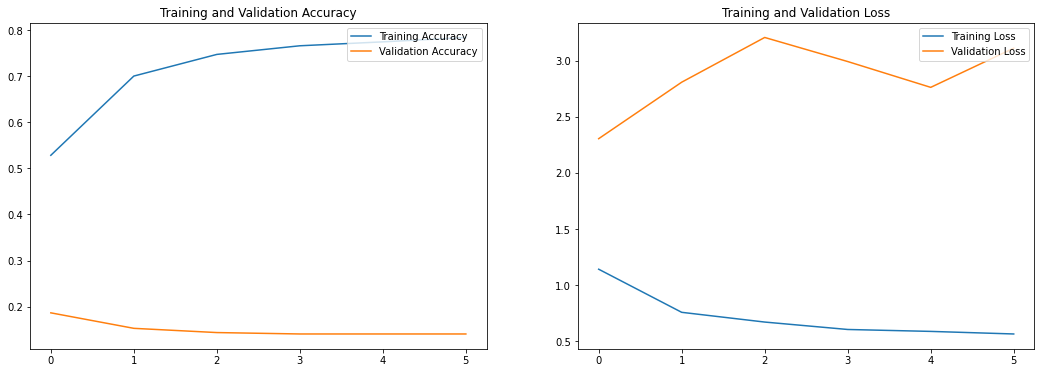

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
predicted_labels = model.predict(X_test)
print(predicted_labels[:5])

[[0.71168333 0.11143469 0.14016382 0.03671816]
 [0.8587084  0.02505144 0.10623062 0.01000955]
 [0.74630636 0.01682861 0.22360747 0.01325764]
 [0.92602444 0.0082588  0.02637543 0.03934134]
 [0.7881188  0.03526382 0.09309132 0.0835261 ]]


In [33]:
predicted_labels = [np.argmax(i) for i in predicted_labels]
print(predicted_labels[:5])

[0, 0, 0, 0, 0]


In [34]:
original_labels =[np.argmax(i) for i in y_test]
print(original_labels[:5])

[3, 1, 2, 3, 1]


In [35]:
from sklearn.metrics import classification_report,confusion_matrix

conf_mat = confusion_matrix(original_labels, predicted_labels)
report = classification_report(original_labels, predicted_labels)

print('Confusion Matrix ==>')
print(conf_mat)
print('----------------------------------------------------------------------------------------')
print('Classification Report ==>')
print(report)

Confusion Matrix ==>
[[ 46   2   0   0]
 [100   0   0   0]
 [ 93   0   0   0]
 [ 86   0   0   0]]
----------------------------------------------------------------------------------------
Classification Report ==>
              precision    recall  f1-score   support

           0       0.14      0.96      0.25        48
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00        86

    accuracy                           0.14       327
   macro avg       0.04      0.24      0.06       327
weighted avg       0.02      0.14      0.04       327



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
predicted_labels = [inverse_class_map[x] for x in predicted_labels]
print(predicted_labels[:5])

['no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor']
